Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then step by step run the code blocks. If you pass all code blocks, remember to **Save** and **Submit** your notebook to the system.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Nguyễn Duy Đạt"

---

# SỬ DỤNG MẠNG CNN HUẤN LUYỆN SẴN (PRETRAINED MODEL)

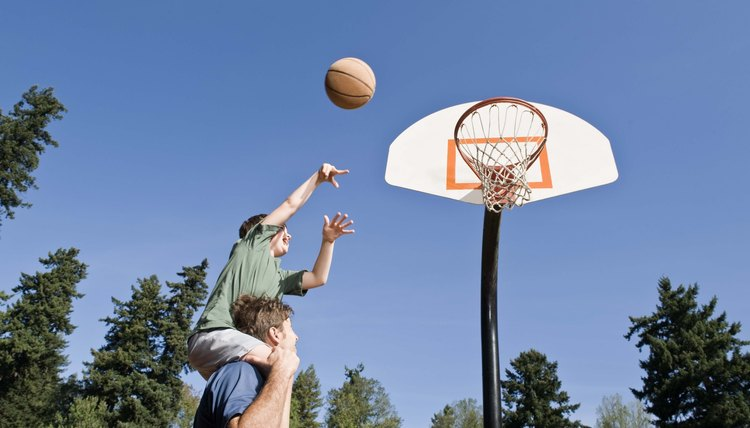

Ở bài tập trước, các bạn đã cài đặt và thực hiện một số thao tác cơ bản như huấn luyện, kiểm thử trên một mạng CNN. Đặc biệt, các bạn đã tạo và so sánh hiệu năng của những biến thể khác nhau của LeNet.

Thực tế, việc xây dựng và huấn luyện một mạng CNN từ đầu cũng giống như việc chúng ta "re-invent the wheel" vậy. Điều này vừa tốn thời gian huấn luyện, vừa cho hiệu năng không cao (so với mô hình đã tune rất kỹ của tác giả), đặc biệt với những mô hình phức tạp và dữ liệu lớn. Vậy thì, tại sao ta không **đứng trên vai người khổng lồ**: tận dụng những mô hình đã huấn luyện sẵn để giải quyết các tác vụ của mình.

Bài tập hôm nay sẽ giúp các bạn biết cách tận dụng một mô hình CNN huấn luyện sẵn, và tinh chỉnh (finetune) cho phù hợp với tác vụ của mình mà bỏ ra công sức ít nhất, nhưng vẫn đạt được hiệu quả cao!

Quảng cáo vậy đủ rồi. *"Get Go"*!

## 1. Chuẩn bị dữ liệu huấn luyện

Bài tập này ta sẽ sử dụng tập dữ liệu `CIFAR-10` với **10 loại đối tượng** thường gặp ở *độ phân giải thấp*. `CIFAR-10` phức tạp hơn so với `MNIST` dùng ở bài tập trước vì đây là ảnh màu `RGB`, các đối tượng có đường nét phức tạp hơn.

Dĩ nhiên, `Keras` cũng sẽ hỗ trợ chúng ta tập dữ liệu này thông qua thư viện có sẵn `keras.datasets`:

In [1]:
# Khai báo thư viện và các hàm cơ bản
import os

import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import preprocess_input
import time
import matplotlib.pyplot as plt

# Hàm này để cố định random seed, phục vụ cho việc đánh giá.
# Vui lòng đừng sửa!!!
def fix_random_seed():
    np.random.seed(1)
    tf.random.set_seed(1)
accuracy = lambda y_true, y_pred: (y_true==y_pred).sum()/len(y_true)

In [16]:
# Tải dữ liệu của CIFAR-10 bao gồm tập huấn luyện và tập kiểm tra
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train[:,0]
y_test = y_test[:,0]
# Lưu ý rằng: y_train và y_test chỉ lưu chỉ mục chứ không lưu tên thật sự của đối tượng
# Do đó, ta cần có biến `classes` để ánh xạ từ chỉ mục y_trrain hoặc y_test sang 
# các tên gọi đời thường của đối tượng
cifar10_classes  = ["airplane", "automobile", "bird", "cat", "deer", 
                    "dog", "frog", "horse", "ship", "truck",]

In [3]:
print("Thông tin kích thước của dữ liệu huấn luyện và dữ liệu kiểm tra: ")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Thông tin kích thước của dữ liệu huấn luyện và dữ liệu kiểm tra: 
(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [4]:
print('Ý nghĩa kích thước các biến trên: ')
print('Số mẫu huấn luyện: {} mẫu'.format(x_train.shape[0]))
print('Số mẫu kiểm tra: {} mẫu'.format(x_test.shape[0]))
print('Kích thước ảnh đầu vào: ', x_train.shape[1:])

Ý nghĩa kích thước các biến trên: 
Số mẫu huấn luyện: 50000 mẫu
Số mẫu kiểm tra: 10000 mẫu
Kích thước ảnh đầu vào:  (32, 32, 3)


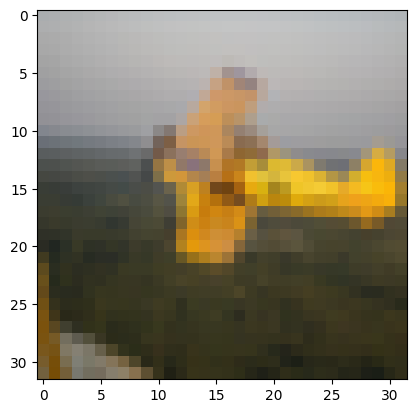

Nhãn (label) của ground-truth:  airplane


In [5]:
# Code block này hiển thị một mẫu dữ liệu train. 
# Đây là việc NÊN LÀM khi bắt đầu với bất kỳ dữ liệu nào
# Ở đây ta sẽ load mẫu dữ liệu thứ 1234. Các bạn có thể thay đổi giá trị này tùy ý
import matplotlib.pyplot as plt

sample_id = 1234
plt.imshow(x_train[sample_id])
plt.show()
print('Nhãn (label) của ground-truth: ', cifar10_classes[y_train[sample_id]])

Bạn có thấy ảnh trên có giống là một chiếc `máy bay` (airplane) hay không?

## 2. Tiền xử lý dữ liệu
Việc chuẩn hóa dữ liệu bao gồm hai nhóm công việc chính:
* Đối với output `y`: chuyển đổi **từ dạng nhãn (label) sang dạng one-hot encoding**.
* Đối với input `x`: chuẩn hóa các giá trị mức sáng **từ [0-255] về đoạn [0-1]**. Bước này cải tiến tốc độ huấn luyện một cách đáng kể.

In [17]:
# Chuyển đổi từ dạng label sang dạng one-hot encoding
# Để tiện sử dụng tensorflow cũng cung cấp cho chúng ta hàm 
# one_hot với đầu vào yêu cầu 2 giá trị là class ID  và số lượng class
y_train_oh = tf.one_hot(y_train, len(cifar10_classes))
print('Kích thước nhãn dữ liệu train ở dạng one-hot encoding: ',y_train_oh.shape)

y_test_oh = tf.one_hot(y_test, len(cifar10_classes))
print('Kích thước nhãn dữ liệu test ở dạng one-hot encoding: ',y_test_oh.shape)

# Chuẩn hóa ảnh đầu vào theo các các tiền xử lý của ResNet 50
x_train_norm = preprocess_input(x_train)
x_test_norm = preprocess_input(x_test)

Kích thước nhãn dữ liệu train ở dạng one-hot encoding:  (50000, 10)
Kích thước nhãn dữ liệu test ở dạng one-hot encoding:  (10000, 10)


In [7]:
# Các bạn có thể xem dữ liệu trước và sau khi tiền xử lý
# Các bạn có thể thay đổi sample_id bằng số tùy ý
sample_id = 4321
print("`y` TRƯỚC khi biến đổi: ", y_train[sample_id])
print("`y` SAU khi biến đổi: ", y_train_oh[sample_id])

`y` TRƯỚC khi biến đổi:  9
`y` SAU khi biến đổi:  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)


In [8]:
print("`x` TRƯỚC khi biến đổi: ", x_train[sample_id])
print("`x` SAU khi biến đổi: ", x_train_norm[sample_id])

`x` TRƯỚC khi biến đổi:  [[[130 126 127]
  [121 135 134]
  [127 138 138]
  ...
  [223 225 230]
  [224 226 230]
  [223 229 229]]

 [[134 127 126]
  [124 131 128]
  [131 135 133]
  ...
  [222 228 231]
  [224 229 231]
  [226 231 232]]

 [[143 125 124]
  [141 131 127]
  [146 132 130]
  ...
  [222 232 231]
  [225 233 233]
  [229 234 235]]

 ...

 [[144 154 145]
  [154 147 143]
  [157 119 125]
  ...
  [226 226 226]
  [225 225 225]
  [227 227 227]]

 [[147 154 147]
  [148 148 146]
  [151 139 142]
  ...
  [225 225 225]
  [224 224 224]
  [225 225 225]]

 [[151 148 146]
  [146 146 147]
  [147 150 153]
  ...
  [225 225 225]
  [223 223 223]
  [223 223 223]]]
`x` SAU khi biến đổi:  [[[ 23.060997    9.221001    6.3199997]
  [ 30.060997   18.221      -2.6800003]
  [ 34.060997   21.221       3.3199997]
  ...
  [126.061     108.221      99.32     ]
  [126.061     109.221     100.32     ]
  [125.061     112.221      99.32     ]]

 [[ 22.060997   10.221001   10.32     ]
  [ 24.060997   14.221001    0.319

## 3. Các cách sử dụng mạng huấn luyện sẵn

Trong thư viện `Keras` ta có thể sử dụng kho mô hình đã huấn luyện sẵn `tensorflow.keras.applications.resnet50`:

In [3]:
# Trong toàn bộ 
from tensorflow.keras.applications.resnet50 import ResNet50

### 3.1. Dùng trực tiếp pretrained model với tập nhãn của ImageNet

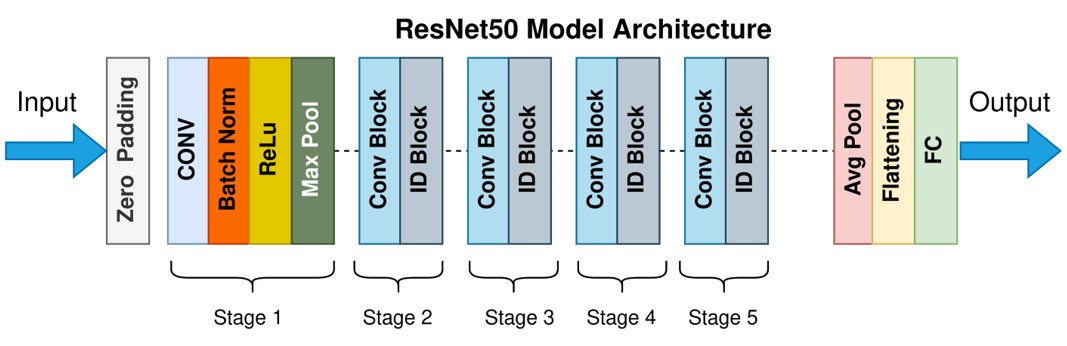

Ở bước này, chúng ta sử dụng mô hình `ResNet50` đã được huấn luyện sẵn trên tập `ImageNet` để dự đoán cho một số ảnh của tập `CIFAR-10`.

Việc **sử dụng trực tiếp** chỉ thực hiện được khi **tập nhãn của dữ liệu mới trùng với tập nhãn sử dụng cho mô hình huấn luyện sẵn**.

Với cách này, ta không làm gì khác với ngoài việc truyền dữ liệu test vào mô hình.

LƯU Ý: Nói là không làm gì, nhưng thực ra là phải:
- Kiểm tra xem kích thước đầu vào của ảnh có khớp với mô hình huấn luyện sẵn hay không? Nếu **kích thước không khớp** ta phải đưa về kích thước đúng của mô hình huấn luyện sẵn.
- Chuẩn hóa ảnh đầu vào giống như khi huấn luyện trên pretrained model.

2023-04-12 06:40:26.920064: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 60211200 exceeds 10% of free system memory.
2023-04-12 06:40:27.205617: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 60211200 exceeds 10% of free system memory.


7


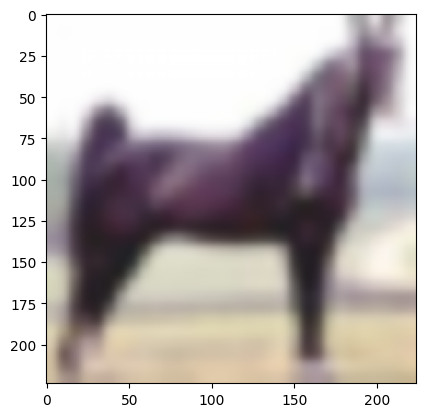

In [18]:
import random
import time
# Khởi tạo và xáo trộn thứ tự dữ liệu trong tập test
temp = list(zip(x_test, y_test))
random.Random(4).shuffle(temp)
x_test_shuf, y_test_shuf = zip(*temp)
x_test_shuf, y_test_shuf = list(x_test_shuf), list(y_test_shuf)

# dùng 100 mẫu của tập test
x_test_subset = x_test_shuf[:100]
y_test_subset = y_test_shuf[:100]

# Thay đổi kích thước ảnh test `x_test` về kích thước 
# mà mô hình pretrained cần.
# Cụ thể, ta cần đổi từ kích thước của tập CIFAR sang kích thước `224x224`
x_test_subset_resized = tf.cast(tf.image.resize(x_test_shuf[:100], (224, 224), method='gaussian'), dtype=float)

# Chuẩn hóa x_test theo đầu vào của ResNet50-ImageNet

x_test_subset_resized_norm = preprocess_input(x_test_subset_resized)

# Trực quan hóa dữ liệu trước khi chính thức ... xử lý
plt.imshow(np.array(x_test_subset_resized[0], dtype=int))
print(y_test_shuf[0])

Các bạn đã đoán ra đây là con gì chưa? OK, cứ giữ lấy suy đoán đó và xem quá trình test có đúng như bạn nghĩ không nhé?

In [11]:
# Cố định giá trị sinh ra ngẫu nhiên
fix_random_seed()

# TODO: Khởi tạo ResNet50 với weights train từ ImageNet và sử dụng trực tiếp để dự đoán nhãn đối tượng
# (còn gọi là tái sử dụng các lớp FC cuối cùng).
# Nhiệm vụ của bạn là sử dụng thư viện `keras` để khởi tạo biến
# `pretrained_resnet50` chứa mô hình ResNet50 đã huấn luyện trên ImageNet
# và bao gồm luôn các lớp FC cuối.
pretrained_resnet50 = None

# YOUR CODE HERE
pretrained_resnet50 = ResNet50(include_top=True, weights='imagenet')


# TODO: Sau khi đã khởi tạo biến mô hình `pretrained_resnet50` xong, 
# hãy dự đoán nhãn của một 100 mẫu trên tập test 'x_test_subset_resized_norm'
# đã chuẩn bị ở code block trước đó. Kết quả của việc dự đoán sẽ lưu ở 
# biến `y_pred`.
y_pred = None

# YOUR CODE HERE
y_pred = pretrained_resnet50.predict(x_test_subset_resized_norm)

4/4 [==============================] - 9s 2s/step


In [12]:
# Kiểm tra số layer không đổi
assert len(pretrained_resnet50.layers) == 177
# Kiểm tra một số lớp trong kiến trúc mạng Alpha
assert str(type(pretrained_resnet50.layers[0]))== "<class 'keras.engine.input_layer.InputLayer'>"
assert str(type(pretrained_resnet50.layers[1]))== "<class 'keras.layers.reshaping.zero_padding2d.ZeroPadding2D'>"
assert str(type(pretrained_resnet50.layers[10]))== "<class 'keras.layers.convolutional.conv2d.Conv2D'>"
assert str(type(pretrained_resnet50.layers[170]))== "<class 'keras.layers.core.activation.Activation'>"
# Kiểm tra hàm activation của lớp convolution
assert pretrained_resnet50.layers[10].activation(1.0) == 1.0
assert pretrained_resnet50.layers[10].activation(-1.0) == -1.0

In [13]:
# Kiểm tra với bộ test ẩn

In [14]:
# Tìm nhãn của các ảnh test sau khi sử dụng pretrained model
# LƯU Ý: Nhãn ở đây là nhãn trên tập dữ liệu ImageNet chứ không phải CIFAR-10
y_pred_output = []
y_pred_output = [np.where(y_pred[i]==np.max(y_pred[i]))[0][0] for i in range(len(y_pred))]

Ở code block trước, bạn đã dữ đoán nhãn phân loại ở dạng chỉ mục (ví dụ 404, 94, ...).

Đây là các chỉ mục trong danh sách 1000 đối tượng của tập dữ liệu `ImageNet`. Để có thể sử dụng được, bạn cần **map** sang nhãn của tập dữ liệu `CIFAR-10`

In [15]:
# Để map từ chỉ mục của ImageNet sang nhãn của CIFAR-10
# Ta cần có bảng tra từ 'label' của CIFAR-10 sang chỉ mục của ImageNet
# Biến `imagnet_used_classes_dict` sẽ thực hiện công việc này
imagnet_used_classes_dict = {
    "airplane": 404, # 'airliner'
    "automobile": 436, # 'beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon'
    "bird": 94, # 'hummingbird'
    "cat": 284, # 'Siamese cat, Siamese'
    "deer": 345, # 'ox'
    "dog": 207, # 'golden retriever'
    "frog": 32, # 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui'
    "horse": 340, # 'zebra'
    "ship": 510, # 'container ship, containership, container vessel'
    "truck": 867 # 'trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi'
}

y_test_subset_mapping = []
y_test_subset_mapping =  np.array([imagnet_used_classes_dict[cifar10_classes[y_test_subset[i]]] for i in range(len(y_test_subset))])

In [16]:
# Hàm tính độ đo accuracy phục vụ đánh giá mô hình
accuracy = lambda y_true, y_pred: (y_true==y_pred).sum()/len(y_true)
acc = accuracy(y_test_subset_mapping, y_pred_output)
print('Độ chính của pretrained ResNet50 trên 100 mẫu dữ liệu CIFAR-10:', acc)

Độ chính của pretrained ResNet50 trên 100 mẫu dữ liệu CIFAR-10: 0.05


Sau khi thực hiện cách sử dụng trực tiếp này, độ chính xác mà nhận được là bao nhiêu khi sử dụng pretrained `ResNet50` trên tập `ImageNet` để test trên tập `CIFAR-10`?

In [17]:
options = ['khoảng 5%', ' khoảng 10%', 'khoảng 15%', 'khoảng 20%']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 0

print("Độ chính xác của pretrained ResNet50:", options[your_choice])

Độ chính xác của pretrained ResNet50: khoảng 5%


Bạn cảm thấy thế nào? Thất vọng tràn trề? Tại sao tập `ImageNet` lớn là thế, mô hình `ResNet50` nổi tiếng là thế, nhưng khi thử trên tập `CIFAR-10` *bé xíu* thì kết quả **fail quá fail**.

In [18]:
# Bộ test ẩn

### 3.2. Kết hợp đặc trưng của mô hình huấn luyện sẵn với thuật toán KNN

Nhắc lại: Trong thư viện Keras có cung cấp sẵn các mô hình học sâu phổ biến và cả mô hình huấn luyện sẵn (pre-trained weight) trên tập ImageNet của chúng.

Cách sử dụng mô hình huấn luyện sẵn sau đây sẽ:
- Chỉ sử dụng các lớp Convolution như là bước rút trích đặc trưng
- Bỏ các lớp Fully Connected (sử dụng để phân loại trên tập dữ liệu pretrained)
- Kết hợp với một classifier khác là KNN

Tương tự như mục trước, ta sẽ sử dụng `tf.keras.applications` để tải về mạng `ResNet50` huấn luyện sẵn trên tập `ImageNet` để rút trích ra các đặc trưng. Mô hình được lưu trong biến `resnet50`.

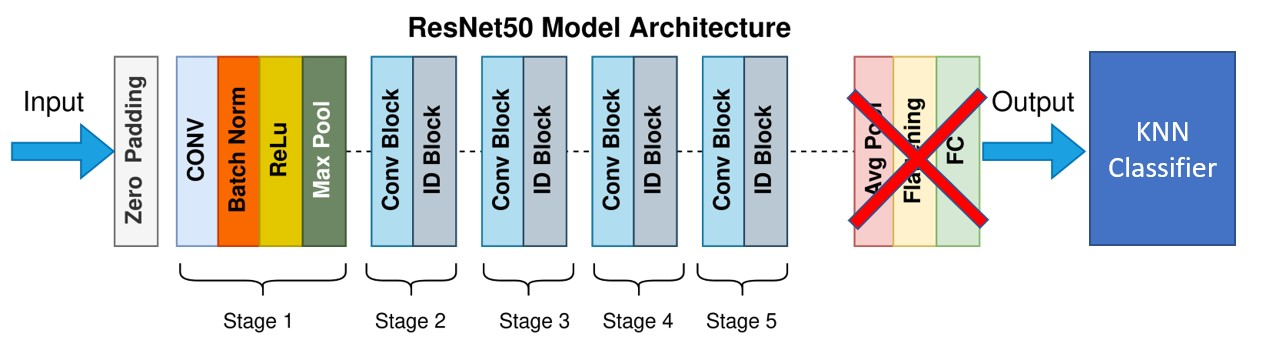

In [19]:
# Cố định giá trị sinh ra ngẫu nhiên
fix_random_seed()

# TODO: Khởi tạo Resnet50 với weights của ImageNet và
# LOẠI BỎ CÁC LỚP FC CUỐI CÙNG (CHÚ Ý QUAN TRỌNG, KẺO LÀM SAI!!!!)
resnet50 = None

# YOUR CODE HERE
resnet50 = ResNet50(include_top=False, weights='imagenet')


Sau khi khởi tạo mạng, chúng ta sẽ in tóm tắt kiến trúc mạng để xem

In [21]:
# Sau khi đã tải về mô hình xong, ta sẽ kiểm tra xem nó có bao gồm
# các lớp FC phía sau hay không bằng lệnh `summary`.
# Lưu ý: mô hình sẽ rất dài đấy.
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [22]:
# TODO: Dùng ResNet50 để rút trích các đặc trưng được đặt của `x_train_norm` và `x_test_norm`
# Các đặc trưng lưu trong các biến# `vector_train` và `vector_test` tương ứng.
# Để rút trích đặc trưng, ta sử dụng hàm `predict` trên biến mô hình đã khởi tạo
# ở bước trước đó.
vector_train = None
vector_test = None

# YOUR CODE HERE
vector_train = resnet50.predict(x_train_norm)
vector_test = resnet50.predict(x_test_norm)

313/313 [==============================] - 24s 75ms/step


In [23]:
# Convert đặc trưng dạng Tensor sang dạng vector
# Biết rằng, ta cần chuyển đổi tensor từ:
# (số lượng đặc trưng x w x h x c) sang (số lượng đặc trưng x (w * h * c))
# Cụ thể là từ (Số vector x 1 x 1 x 2048) => (Số vector x 2048)
vector_train   = vector_train[:,0,0,:]
vector_test    = vector_test[:,0,0,:]

print('Kích thước của vector train:', vector_train.shape)
print('Kích thước của vector test:', vector_test.shape)

Kích thước của vector train: (50000, 2048)
Kích thước của vector test: (10000, 2048)


Sau khi đã trúc trích đặc trưng của các ảnh thành vector, ta sẽ sử dụng thuật toán KNN để phân loại các ảnh trong tập kiểm tra. Thuật toán này dựa trên `K` điểm (vector) lân cận để phân loại điểm mới. Thuật toán KNN (`KNeighborsClassifier`) được cài đặt sẳn trong thư viện `sklearn.neighbors`.

In [24]:
from sklearn.neighbors import KNeighborsClassifier

# TODO: Khởi tạo mô hình KNN với tham số K=3 sử dụng sklearn
# Bạn cần tạo biến `knn_k3` để chứa mô hình với tham số nêu trên.
# Sau đó, sử dụng phương thức `fit` để huấn luyện trên tập dữ liệu train
# `vector_train`, `y_train`
knn_k3 = None

# YOUR CODE HERE
knn_k3 = KNeighborsClassifier(n_neighbors=3)
knn_k3.fit(vector_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Sau khi đã huấn luyện với thuật toán KNN, hãy tiến hành test trên tập test.

In [25]:
# `start` và `end` dùng để đo thời gian thực thi
start = time.time()

# Dự đoán trên tập test và đánh giá độ chính xác
y_pred_k3 = knn_k3.predict(vector_test)
knn_k3_acc = accuracy(y_test, y_pred_k3)
print('Độ chính xác của thuật toán KNN với K=3 là:', knn_k3_acc)

end = time.time()
print('Thời gian xử lý (giây): ', end - start)

Độ chính xác của thuật toán KNN với K=3 là: 0.538
Thời gian xử lý (giây):  24.221802473068237


In [26]:
att = {'algorithm': 'auto',
    'leaf_size': 30,
    'metric': 'minkowski',
    'metric_params': None,
    'n_jobs': None,
    'n_neighbors': 3,
    'p': 2,
    'weights': 'uniform'}
# kiểm tra các tham số và dự đoán
assert knn_k3.get_params() == att
assert all(y_pred_k3[:10] == [5, 1, 8, 0, 6, 6, 1, 0, 5, 9])

In [27]:
# Kiểm tra với bộ test ẩn

Hãy cho biết, sau khi huấn luyện các đặc trưng học sâu với KNN thì kết quả như thế nào?
Sau khi thử xong, hỏi độ chính xác là bao nhiêu?

Ví dụ: Độ chính xác của bạn là 87.9% thì bạn cần chọn đáp số là 80%.

In [28]:
options = ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2, 3, .... tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 1

print("Độ chính của KNN với K=3 đạt được khoảng: ", options[your_choice])

Độ chính của KNN với K=3 đạt được khoảng:  20%


In [29]:
# Kiểm tra với bộ test ẩn

Sau khi thực nghiệm với K=3, chúng ta sẽ tăng K=7 để thực nghiệm và so sánh.

In [31]:
# Huấn luyện lại mô hình với tham số K=7
# TODO: Khởi tạo mô hình KNN với tham số K=7 sử dụng sklearn
# Bạn cần tạo biến `knn_k7` để chứa mô hình giống ở trên nhưng K=7.
# Sau đó, sử dụng phương thức `fit` để huấn luyện trên tập dữ liệu train
# `vector_train`, `y_train`
knn_k7 = None

# YOUR CODE HERE
knn_k7 = KNeighborsClassifier(n_neighbors=7)
knn_k7.fit(vector_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [32]:
# `start` và `end` để đo tốc độ xử lý
start = time.time()

# Dự đoán trên tập test và đánh giá độ chính xác
y_pred_k7 = knn_k7.predict(vector_test)
knn_k7_acc = accuracy(y_test, y_pred_k7)
print('Độ chính xác của thuật toán KNN với K=7 là:', knn_k7_acc)

end = time.time()
print('Thời gian xử lý (giây): ', end - start)

Độ chính xác của thuật toán KNN với K=7 là: 0.5765
Thời gian xử lý (giây):  24.947115898132324


In [33]:
att = {'algorithm': 'auto',
    'leaf_size': 30,
    'metric': 'minkowski',
    'metric_params': None,
    'n_jobs': None,
    'n_neighbors': 7,
    'p': 2,
    'weights': 'uniform'}
# kiểm tra các tham số và dự đoán
assert knn_k7.get_params() == att
assert all(y_pred_k7[:10] == [5, 1, 8, 8, 6, 6, 1, 1, 5, 9])

In [34]:
# Kiểm tra với bộ test ẩn

Sau khi thử xong, hỏi độ chính xác là bao nhiêu?

Ví dụ: Độ chính xác của bạn là 87.9% thì bạn cần chọn đáp số là 80%.

In [35]:
options = ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2, 3, .... tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 2

print("Độ chính của KNN với K=7 đạt được khoảng: ", options[your_choice])

Độ chính của KNN với K=7 đạt được khoảng:  30%


In [36]:
# Kiểm tra với bộ test ẩn

So sánh kết quả của KNN trong hai trường hợp `K=3` và `K=7`:

In [37]:
options = [
    'KNN với K = 3 đạt độ chính xác cao hơn',
    'KNN với K = 3 đạt thực thi nhanh hơn vì thuật toán tính toán ít hơn (cần thử nghiệm nhiều lần)',
    'KNN với K = 7 đạt độ chính xác cao hơn',
    'KNN với K = 7 đạt thực thi nhanh hơn vì thuật toán ít tốn tài nguyên hơn (cần thử nghiệm nhiều lần)',
          ]
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 2

print("Theo tôi thì:", options[your_choice])

Theo tôi thì: KNN với K = 7 đạt độ chính xác cao hơn


In [38]:
# Kiểm tra với bộ test ẩn

### 3.3. Sử dụng đặc trưng học sâu với SVM để phân loại ảnh

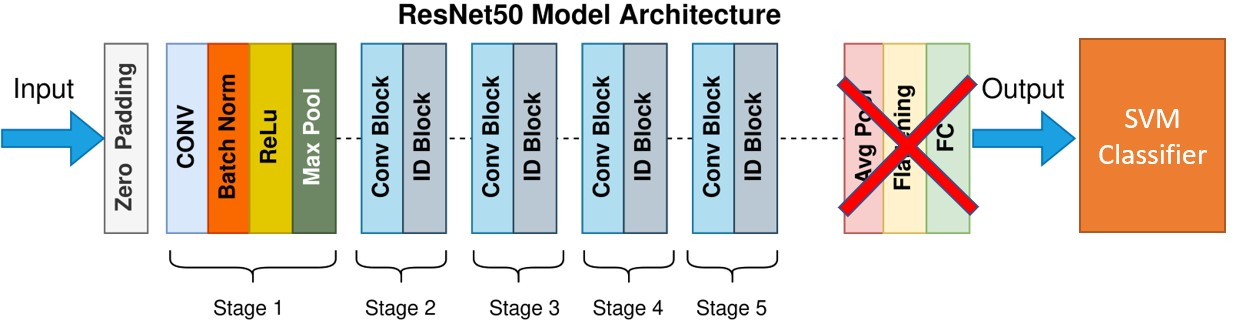

In [8]:
fix_random_seed()

# Khởi tạo resnet50 với weights của imageNet và loại bỏ các lớp FC cuối cùng.
resnet50 = None

# dùng resnet50 để rút trích vector_train và vector_test từ x_train_norm và x_test_norm tương ứng
vector_train = None
vector_test = None
# YOUR CODE HERE
resnet50 = ResNet50(include_top=False, weights='imagenet')
vector_train = resnet50.predict(x_train_norm)
vector_test = resnet50.predict(x_test_norm)

vector_train   = vector_train[:,0,0,:]
vector_test    = vector_test[:,0,0,:]

print('kích thước của vector train:', vector_train.shape)
print('kích thước của vector test:', vector_test.shape)

313/313 [==============================] - 24s 76ms/step
kích thước của vector train: (50000, 2048)
kích thước của vector test: (10000, 2048)


In [9]:
from sklearn.svm import SVC

# Khởi tạo mô hình phân lớp `SVM_clf` với các tham số sau
max_iter_num = 300
kernel_type = 'poly'
gamma_type = 'auto'

SVM_clf = None
# TODO: Sử dụng đối tượng `SVC` với các tham số nêu trên
# Sau đó tiến hành huấn luyện trên các đặc trưng đã rút trích
# YOUR CODE HERE
SVM_clf = SVC(max_iter=max_iter_num, kernel=kernel_type, gamma=gamma_type)
SVM_clf.fit(vector_train, y_train)

/home/ubuntu/anaconda3/envs/digit-lab/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(gamma='auto', kernel='poly', max_iter=300)

In [10]:
# Dự đoán và đánh giá độ chính xác trên tập test
y_pred_SVM = SVM_clf.predict(vector_test)
svm_acc = accuracy(y_test, y_pred_SVM)
print('Độ chính xác của thuật toán SVM là:', svm_acc)

Độ chính xác của thuật toán SVM là: 0.3645


In [11]:
# Kiểm tra việc khởi tạo mô hình với SVM
att = {'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'poly',
 'max_iter': 300,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}
assert SVM_clf.get_params() == att

In [13]:
# Kiểm tra với bộ test ẩn

Độ chính xác của bạn ra được là bao nhiêu?

Ví dụ: Độ chính xác của bạn là 87.9% thì bạn cần chọn đáp số là 80%.

In [12]:
options = ['10%', '20%', '30%', '40%']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 2

print("Độ chính của SVM đạt được khoảng: ", options[your_choice])

Độ chính của SVM đạt được khoảng:  30%


In [14]:
# Kiểm tra với bộ test ẩn

### 3.4. Sử dụng pre-trained model với lớp FC mới
Ở hướng tiếp cận này, ta sẽ tiến hành bỏ các lớp FC cũ, gắn lớp FC mới, sau đó huấn luyện.

Có hai chiến thuật huấn luyện:
- *Huấn luyện hết toàn bộ mạng*: sử dụng khi dữ liệu đủ nhiều hoặc dữ liệu mới không có nhiều sự tương đồng với dữ liệu pretrained.
- *Huấn luyện một phần (phần sau) của mạng*: sử dụng khi dữ liệu huấn luyện mới quá ít hoặc có sự tương đồng cao với tập pretrained.

In [7]:
from keras.layers import Input, Dense, Conv2D, AveragePooling2D, Flatten
from keras.models import load_model, Model
import keras

### 3.4.1 Biến thể Alpha - Huấn luyện lại toàn bộ
Ta thêm các lớp Fully-Connected (FC) vào mạng học sâu để thay đổi đầu ra (các giá trị dự đoán) phù hợp với bài toán và huấn luyện toàn bộ mạng. Ở đây, ta vẫn sẽ sử dụng `ResNet50` cho kiến trúc mạng, sau đó sẽ có 2 lớp FC cùng với 2 lớp activation là `ReLU` và `Softmax`. Lớp FC đầu có `1024` node.

Chú ý ở đây ta sẽ dùng activation từ layers của Keras, không dùng trong tham số của lớp `Dense`.

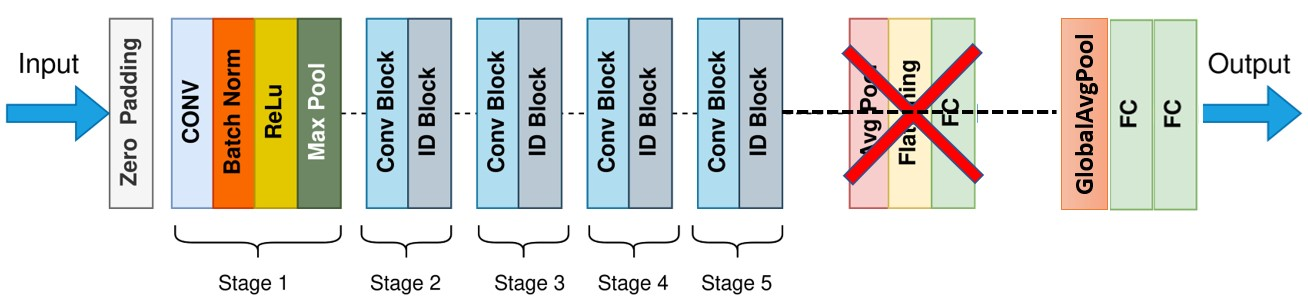

In [11]:
class AlphaResNet50:
    # constructor
    def __init__(self):
        self.model = None

    # Định nghĩa kiến trúc của mô hình
    def build(self, input_dim):
        input = Input(shape = input_dim) # input

        # TODO: Khởi tạo mô hình pre-trained ResNet50 với các lớp FC mới
        # Bạn cần tạo biến `alpha` để chứa mô hình pre-trained ResNet50 và 2 lớp FC mới, với lớp đầu có 1024 node. 
        # Sử dụng `tf.keras.Sequential` để ghép các layers lại với nhau.
        # lưu ý: có lớp `GlobalAveragePooling2D` giữa pre-trained ResNet50 với các lớp FC mới.
        resnet50 = None
        alpha = None
        # YOUR CODE HERE
        resnet50 = ResNet50(input_tensor=input, weights='imagenet', include_top=False)
        for layer in resnet50.layers:
            layer.trainable = False
        
        alpha = keras.Sequential(
            [
                resnet50,
                keras.layers.GlobalAveragePooling2D(),
                Dense(1024),
                keras.layers.ReLU(),
                Dense(10),
                keras.layers.Softmax()
            ]
        )
        
        output = alpha(input)
        
        self.model = Model(input, output)

    # Huấn luyện mô hình
    def train(self, x_train, y_train): # x_train chinh la X, y_train chinh la ground-truth
        opt = tf.keras.optimizers.SGD(learning_rate=1e-2) # Stochastic Gradient Descent
        self.model.compile(optimizer=opt, loss='categorical_crossentropy') # CCE loss
        self.model.fit(x_train, y_train, epochs = 1, batch_size = 64)

    # Load mô hình từ file
    def load(self, model_file):
        self.model = load_model(model_file)

    # Lưu mô hình hiện tại xuống file
    def save(self, model_file):
        self.model.save(model_file)

    # Tóm tắt kiến trúc mạng
    def summary(self):
        self.model.layers[1].summary()

    # Thử nghiệm mô hình với dữ liệu ảnh đầu vào
    def predict(self, x_test):
        return self.model.predict(x_test)

In [12]:
fix_random_seed()
# TODO: Khởi tạo mô hình Alpha đã định nghĩa ở trên
# Bạn cần tạo biến `alpha` dựa trên class `AlphaResNet50` ở trên 
# và chạy phương thức `build` để xây dựng model

input_dim = None
alpha =  None
# # YOUR CODE HERE
input_dim = (32, 32, 3)
             
alpha = AlphaResNet50()
alpha.build(input_dim)
layers = alpha.model.layers[1].layers
print(type(layers[-1]))    
# resnet50 = ResNet50(weights='imagenet', include_top=False)
# resnet50.get_layer('conv5_block3_out').output

<class 'keras.layers.activation.softmax.Softmax'>


In [13]:
# In tổng quát kiến trúc của Alpha
alpha.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 re_lu_1 (ReLU)              (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                                 
 softmax_1 (Softmax)         (None, 10)                0         
                                                      

In [14]:
fix_random_seed()
test_set = [[0.03153765, 0.44503546, 0.13921872, 0.03935978, 0.027875,0.03556212, 0.1035661 , 0.077412  , 0.0542849 , 0.04614821]]
# Kiểm tra một số lớp trong kiến trúc mạng Alpha
layers = alpha.model.layers[1].layers
assert len(layers) == 6
assert str(type(layers[-2]))=="<class 'keras.layers.core.dense.Dense'>"
assert str(type(layers[-1]))=="<class 'keras.layers.activation.softmax.Softmax'>"
assert layers[-2].weights[0].shape[1]==10
assert tf.reduce_all((layers[-1](tf.random.normal((1, 10)))-test_set)<9e-8)
print('Bạn đã qua vòng kiểm tra!!!')

Bạn đã qua vòng kiểm tra!!!


In [ ]:
# Kiểm tra với bộ test ẩn

In [19]:
# huấn luyện mô hình với dữ liệu đã được xử lý `x_train_norm`, `y_train_oh`
alpha.train(x_train_norm, y_train_oh)

782/782 [==============================] - 221s 275ms/step - loss: 1.2802


In [20]:
y_pred = alpha.predict(x_test_norm)
alpha_acc = accuracy(y_test, y_pred.argmax(axis=1))
print('Độ chính xác của Alpha', alpha_acc)

313/313 [==============================] - 44s 133ms/step
Độ chính xác của Alpha 0.6286


In [21]:

options = ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2, 3, .... tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 5

print("Độ chính của Alpha đạt được trên", options[your_choice])

Độ chính của Alpha đạt được trên 60%


In [ ]:
# Kiểm tra với bộ test ẩn

Theo bạn giữa phiên bản SVM, KNN(K=7), Alpha, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [22]:
options = {0: 'Không có ý kiến', 
            1: 'SVM tốt hơn Alpha', 
            2: 'Alpha tệ hơn KNN', 
            3: 'Alpha tệ hơn KNN và SVM',
            4: 'Alpha tốt hơn KNN',
            5: 'Alpha tốt hơn SVM',
            6: 'Alpha tốt hơn KNN và SVM',
          }

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2, 3, 4, 5 hoặc 6 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 6

print("Theo mình thì: ", options[your_choice])

Theo mình thì:  Alpha tốt hơn KNN và SVM


In [ ]:
# Kiểm tra với bộ test ẩn

### 3.4.2. Biến thể Beta - Chỉ huấn luyện các lớp FC mới
Ở biến thể `Beta`, ta sẽ sử dụng hoàn toàn và không chỉnh sửa mạng pre-trained trên ImageNet, chỉ huấn luyện các lớp mới được thêm vào. Kiến trúc mạng của `Beta` giống với `Alpha` nhưng số lượng tham số huấn luyện ít hơn. 

Hướng dẫn: các bạn đọc thêm thuộc tính `trainable` trong Tensorflow 

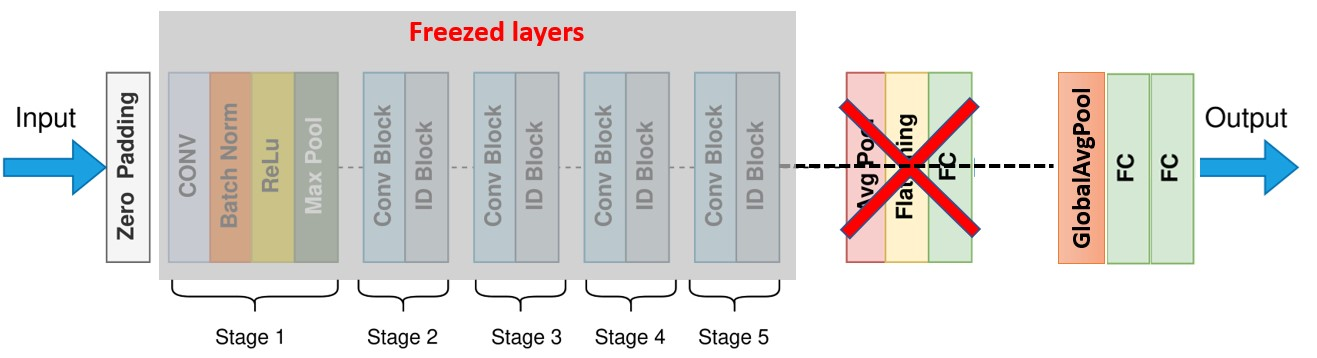

In [28]:
class BetaResNet50(AlphaResNet50):
    # Định nghĩa kiến trúc của mô hình
    def build(self, input_dim):
        input = Input(shape = input_dim) # input
        # TODO: Khởi tạo mô hình pre-trained ResNet50 với các lớp FC mới
        # Tương tự như 'alpha', bạn cần tạo biến `beta` để chứa mô hình pre-trained ResNet50 và 2 lớp FC mới, với lớp đầu có 1024 node. 
        # Đóng băng các lớp của mạng pre-trained resnet50,
        # Sử dụng `tf.keras.Sequential` để ghép pre-trained resnet50 với các layers lại với nhau.
        # lưu ý: có lớp `GlobalAveragePooling2D` giữa pre-trained ResNet50 với các lớp FC mới.

        # YOUR CODE HERE
        resnet50 = ResNet50(input_tensor=input, weights='imagenet', include_top=False)
        for layer in resnet50.layers:
            layer.trainable = False
        
        beta = keras.Sequential(
            [
                resnet50,
                keras.layers.GlobalAveragePooling2D(),
                Dense(1024),
                keras.layers.ReLU(),
                Dense(10),
                keras.layers.Softmax()
            ]
        )
        
        output = beta(input)

        self.model = Model(input, output)

In [29]:
fix_random_seed()

# TODO: Khởi tạo mô hình Beta đã định nghĩa ở trên
# Bạn cần tạo biến `beta` dựa trên class `BetaResNet50` ở trên 
# và chạy phương thức `build` để xây dựng model

input_dim = None
beta =  None
# YOUR CODE HERE
input_dim = (32, 32, 3)
beta =  BetaResNet50()
beta.build(input_dim)

In [30]:
# In tổng quát kiến trúc của Beta
print(beta.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 re_lu_2 (ReLU)              (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 10)                10250     
                                                                 
 softmax_2 (Softmax)         (None, 10)                0         
                                                      

In [31]:
# Kiểm tra kiến trúc Beta

fix_random_seed()
test_set = [[0.03153765, 0.44503546, 0.13921872, 0.03935978, 0.027875,0.03556212, 0.1035661 , 0.077412  , 0.0542849 , 0.04614821]]
# Kiểm tra một số lớp trong kiến trúc mạng Beta
layers = beta.model.layers[1].layers
assert len(layers) == 6
assert str(type(layers[1]))=="<class 'keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>"
assert str(type(layers[2]))=="<class 'keras.layers.core.dense.Dense'>"
assert str(type(layers[4]))=="<class 'keras.layers.core.dense.Dense'>"
assert layers[-2].weights[0].shape[1]==10
assert tf.reduce_all((layers[-1](tf.random.normal((1, 10)))-test_set)<9e-8)
assert sum([tf.size(i) for i in beta.model.trainable_variables])==2108426
print('Bạn đã qua vòng kiểm tra!!!')

Bạn đã qua vòng kiểm tra!!!


In [ ]:
# Kiểm tra với bộ test ẩn

In [ ]:
# huấn luyện mô hình với dữ liệu đã được xử lý `x_train_norm`, `y_train_oh`
beta.train(x_train_norm, y_train_oh)

725/782 [==========================>...] - ETA: 18s - loss: 1.3010

In [ ]:
y_pred = beta.predict(x_test_norm)
beta_acc = accuracy(y_test, y_pred.argmax(axis=1))
print('Độ chính xác của Beta là: ', beta_acc)

In [3]:
options = ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2, 3, .... tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 5

print("Độ chính của Beta đạt được trên", options[your_choice])

Độ chính của Beta đạt được trên 60%


In [ ]:
# Kiểm tra với bộ test ẩn

Theo bạn giữa phiên bản Alpha và Beta, bạn thấy kết quả có sự thay đổi đáng kể hay không?

In [1]:
options = ['Không có ý kiến', 'Alpha tốt hơn Beta', 'Alpha tệ hơn Beta', 'Alpha ngang ngửa Beta (chênh không quá 1%)']

your_choice = None

# Hãy chọn your_choice bằng 0, 1, 2 hoặc 3 tương ứng với các lựa chọn ở trên
# YOUR CODE HERE
your_choice = 3

print("Theo tôi thì: ", options[your_choice])

Theo tôi thì:  Alpha ngang ngửa Beta (chênh không quá 1%)


In [ ]:
# Kiểm tra với bộ test ẩn

Phew!! Vậy là bạn đã trải nghiệm cảm giác *đứng trên vai người khổng lồ* là thế nào rồi phải không. Không quá cầu kỳ, ta có thể sử dụng pretrained model như một **bộ rút trích đặc trưng**. Xa hơn nữa, ta có thể kết hợp thêm với các mô hình máy học, chỉnh sửa mô hình học sâu để **tinh chỉnh mô hình**.